In [154]:
import os
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

In [215]:
def list_files_with_full_path(folder_path):
    try:
        # Get the list of files in the folder with full paths
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except OSError as e:
        print(f"Error reading files in {folder_path}: {e}")
        return None
    
def get_csv(bag_name):
    
    data_dict = {}
    
    # Read bag
    b = bagreader(bag_name)
    
    for topic in b.topics: 
        data = b.message_by_topic(topic)
        data_dict['{}'.format(topic)] = pd.read_csv(data)
        
    return data_dict

# Transform stuff
def create_T(p, q): 
    
    r = R.from_quat([q[0], q[1], q[2], q[3]])
    r = r.as_matrix()
                     
    T = np.matrix([[r[0, 0], r[0, 1], r[0, 2], p[0]], 
                   [r[1, 0], r[1, 1], r[1, 2], p[1]],
                   [r[2, 0], r[2, 1], r[2, 2], p[2]], 
                   [0, 0, 0, 1]])
    return T
                 
def get_p_from_T(T_0P):
    
    x = [T_0P_[0, 3] for T_0P_ in T_0P]
    y = [T_0P_[1, 3] for T_0P_ in T_0P]
    z = [T_0P_[2, 3] for T_0P_ in T_0P]
    
    return(x, y, z)

def transform_to_marker_tip(x, y, z, qx, qy, qz, qw, T_TP): 
    
    T_0T = [create_T((x_, y_, z_), (qx_, qy_, qz_, qw_)) for x_, y_, z_, qx_, qy_, qz_, qw_ in zip(x, y, z, qx, qy, qz, qw)]
    T_0P = [np.dot(T_0T_, T_TP) for T_0T_ in T_0T]
    
    x, y, z = get_p_from_T(T_0P)
    
    return x, y, z 

def extract_kalipen(csv, trace):
    if trace: 
        topic_name = '/kdno/MARKER_COLOR'
    else: 
        topic_name = '/kdno/MARKER_BW'
        
    t = csv[topic_name]['Time']
    x = csv[topic_name]['pose.position.x']
    y = csv[topic_name]['pose.position.y']
    z = csv[topic_name]['pose.position.z']
    
    return x,y,z

def extract_robot(csv, T_TP):
    # Same topic name for both recordings
    x = csv['/franka_state_controller/O_T_EE']['pose.position.x'] 
    y = csv['/franka_state_controller/O_T_EE']['pose.position.y']
    z = csv['/franka_state_controller/O_T_EE']['pose.position.z'] 
    qx = csv['/franka_state_controller/O_T_EE']['pose.orientation.x']
    qy = csv['/franka_state_controller/O_T_EE']['pose.orientation.y']
    qz = csv['/franka_state_controller/O_T_EE']['pose.orientation.z']
    qw = csv['/franka_state_controller/O_T_EE']['pose.orientation.w']
    
    x_, y_, z_ = transform_to_marker_tip(x, y, z, qx, qy, qz, qw, T_TP)
    return x_, y_, z_



In [254]:
list_of_bags1 = list_files_with_full_path("./pbd_bags/student11")
list_of_bags2 = list_files_with_full_path("./pbd_bags/student12")
list_of_bags3 = list_files_with_full_path("./pbd_bags/student13")

In [204]:
print(list_of_bags1)
print(list_of_bags2)

['./pbd_bags/student11/student_11_MARKER_COLOR.bag', './pbd_bags/student11/student_11_bw_robot.bag', './pbd_bags/student11/student_11_MARKER_BW.bag', './pbd_bags/student11/student_11_color_robot.bag']
['./pbd_bags/student12/student_12_bw_robot.bag', './pbd_bags/student12/student_12_MARKER_BW.bag', './pbd_bags/student12/student_12_MARKER_COLOR.bag', './pbd_bags/student12/student_12_color_robot.bag']


In [256]:
bags = [bagreader(bag) for bag in list_of_bags3]

[INFO]  Successfully created the data folder ./pbd_bags/student13/student_91_MARKER_BW.
[INFO]  Successfully created the data folder ./pbd_bags/student13/student_91_color_robot.
[INFO]  Successfully created the data folder ./pbd_bags/student13/student_91_bw_robot.
[INFO]  Successfully created the data folder ./pbd_bags/student13/student_91_MARKER_COLOR.


In [238]:
print(bags)

[<bagpy.bagreader.bagreader object at 0x7f07e35bd910>, <bagpy.bagreader.bagreader object at 0x7f07dea68cd0>, <bagpy.bagreader.bagreader object at 0x7f07e3bd7970>, <bagpy.bagreader.bagreader object at 0x7f07e15997c0>]


In [257]:
csvs = [get_csv(bag_name) for bag_name in list_of_bags3]

[INFO]  Data folder ./pbd_bags/student13/student_91_MARKER_BW already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_color_robot already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_bw_robot already exists. Not creating.
[INFO]  Data folder ./pbd_bags/student13/student_91_MARKER_COLOR already exists. Not creating.


In [258]:
# Plots marker movement in space
x_mc, y_mc, z_mc = extract_kalipen(csvs[0], trace=False)
x_mnc, y_mnc, z_mnc = extract_kalipen(csvs[3], trace=True)

x_rc, y_rc, z_rc = extract_robot(csvs[1], T_TP)
x_rnc, y_rnc, z_rnc = extract_robot(csvs[2], T_TP)

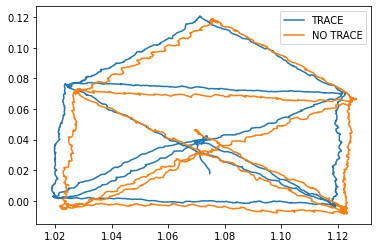

In [247]:
plt.plot(x_mc, z_mc, label='TRACE')
plt.plot(x_mnc, z_mnc, label='NO TRACE')
plt.legend()

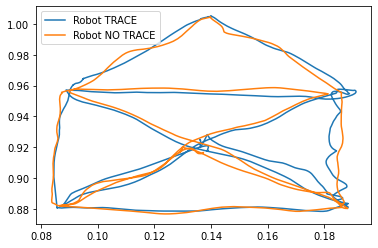

In [248]:
plt.plot(y_rc, z_rc, label="Robot TRACE")
plt.plot(y_rnc, z_rnc, label="Robot NO TRACE")
plt.legend()

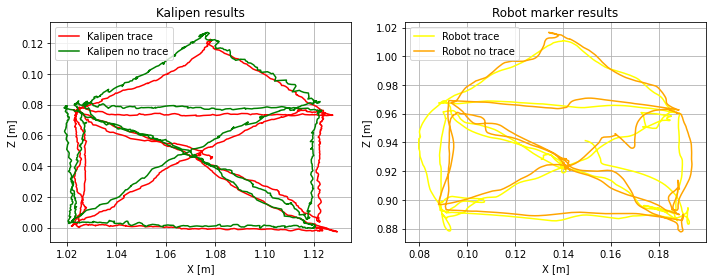

In [260]:
# Create a subplot with a 1x2 grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the first graph on the left
axes[0].plot(x_mc, z_mc, color='red', label='Kalipen trace')
axes[0].plot(x_mnc, z_mnc, color='green', label='Kalipen no trace')
axes[0].set_title('Kalipen results')
axes[0].set_xlabel('X [m]')
axes[0].set_ylabel('Z [m]')
axes[0].legend()
axes[0].grid()

# Plot the second graph on the right
axes[1].plot(y_rc, z_rc, color='yellow', label='Robot trace')
axes[1].plot(y_rnc, z_rnc, color='orange', label='Robot no trace')
axes[1].set_title('Robot marker results')
axes[1].set_xlabel('X [m]')
axes[1].set_ylabel('Z [m]')
axes[1].legend()
axes[1].grid()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

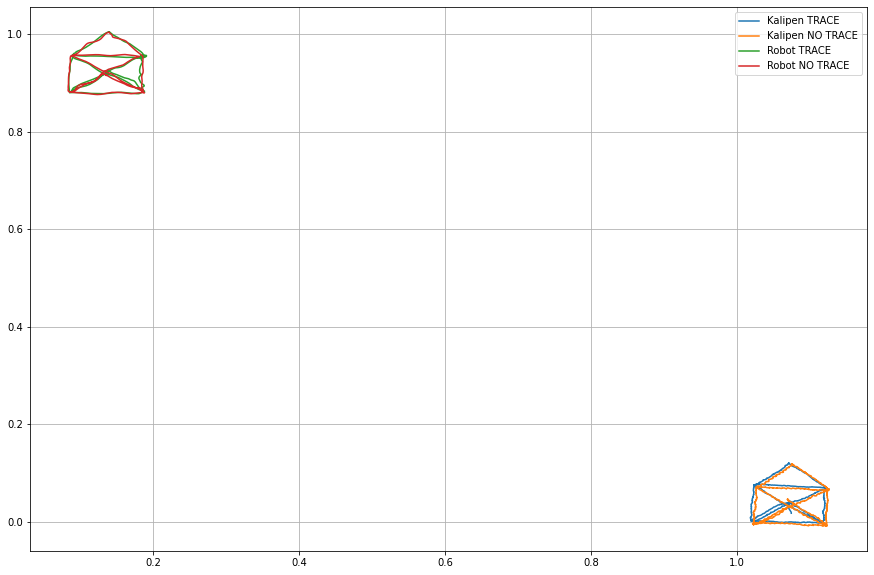

In [250]:
plt.figure(figsize=(15, 10))
plt.plot(x_mc, z_mc, label='Kalipen TRACE')
plt.plot(x_mnc, z_mnc, label='Kalipen NO TRACE')
plt.plot(y_rc, z_rc, label="Robot TRACE")
plt.plot(y_rnc, z_rnc, label="Robot NO TRACE")
plt.legend()
plt.grid()


In [251]:
print(csvs[1]['/franka_state_controller/O_T_EE'])

KeyError: '/franka_state_controller/O_T_EE'

## TODO: 

- [x] Read bags 
- [x] Plot first house
- [x] Plot second house
- [ ] Add TF flandza-pen
- [ ] Making house plotting autonomous
- [ ] Add plotting of the joint states

In [153]:
xc = csvs[1]['/franka_state_controller/O_T_EE']['pose.position.x']
yc = csvs[1]['/franka_state_controller/O_T_EE']['pose.position.y']
zc = csvs[1]['/franka_state_controller/O_T_EE']['pose.position.z']
qx = csvs[1]['/franka_state_controller/O_T_EE']['pose.orientation.x']
qy = csvs[1]['/franka_state_controller/O_T_EE']['pose.orientation.y']
qz = csvs[1]['/franka_state_controller/O_T_EE']['pose.orientation.z']
qw = csvs[1]['/franka_state_controller/O_T_EE']['pose.orientation.w']

T_TP = np.matrix([[1, 0, 0, 0.0015946], 
                  [0, 1, 0, -0.00069987], 
                  [0, 0, 1, 0.14166], 
                  [0, 0, 0, 1]])

xc, yc, zc = transform_to_marker_tip(xc, yc, zc, qx, qy, qz, qw, T_TP)

NameError: name 'T0P' is not defined

In [125]:
qx_ = qx[0]
qy_ = qy[0]
qz_ = qz[0]
qw_ = qw[0]
xc_ = xc[0]
yc_ = yc[0]
zc_ = zc[0]
print(qx_); print(qy_); print(qz_); print(qw_)

-0.0519804598571912
0.7215501039422367
0.0191084592579665
0.6901402242232696
